# Using Machine Learning to Classify Galaxy Morphology

The goal of this project is to create a machine learning algorithm which will be able to classify different galaxy morphologies. For example, we would want to feed it an image like this:

<div>
<img src="title_pic.png" width="200">
</div>

and have the algorithm tell us that this is a spiral galaxy.

To do this, we'll need to create a dataset of a bunch of different pictures of galaxies all labelled with their specific morphology, then create a machine learning algorithm and use most of these pictures to train it, and finally use the rest of the pictures to test how well our algorithm works.

So let's start on that first step of generating a dataset of lots of pictures of galaxies all properly labelled. Thankfully, Henry Leung and Jo Bovy from the university of Toronto have already done this: https://astronn.readthedocs.io/en/latest/galaxy10.html. This Galaxy10 DECals Dataset is a compilation of 17736 galaxy images all sorted into 10 different categories. The categories as well as the number of galaxies per category can be seen in the table below:

| Galaxy Morphology | Number of Images |
| --- | --- |
| Disturbed Galaxies | 1081 |
| Merging Galaxies | 1853 |
| Round Smooth Galaxies | 2645 |
| In-Between Round Smooth Galaxies | 2027 |
| Cigar shaped Smooth Galaxies | 334 |
| Barred Spiral Galaxies | 2043 |
| Unbarred Tight Spiral Galaxies | 1829 |
| Unbarred Loose Spiral Galaxies | 2628 |
| Edge-On Galaxies without Bulge | 1423 |
| Edge-On Galaxies with Bulge | 1873 |

You can download the dataset from here: https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

A final quick note before we get started, to create the machine learning algorithm we are using a library called "TensorFlow". To install this, go to your anaconda powershell prompt and type in `pip install --upgrade tensorflow`. We will also be using the library cv2, so while you're in the prompt, also make sure to type `pip install opencv-python`. Let's make sure the installation worked and load all the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import scipy
import h5py
import cv2
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, PReLU
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report

## Loading the Images

This next block of code loads all 17736 images, so it might take a while.

In [2]:
# Loads the images and labels from the downloaded .h5 file
with h5py.File('data/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Converts the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

Let's take a look at one of these images:

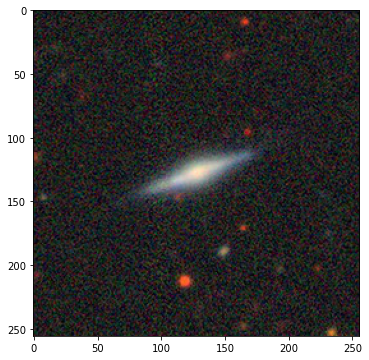

In [3]:
plt.figure(figsize = (6,6))
plt.imshow(images[17735])

## Generating the Dataset

And now let's modify the generated `labels` array so we can work with it. The `labels` array is a 17736x10 array, meaning a 1x10 array for each image. This 1x10 array has zeros in all positions except for the position denoting its morphology, which has a 1. So for example, the label array for a round smooth galaxy would look like this: $[0,0,1,0,0,0,0,0,0,0]$. What we want to do is change this so that each image instead has an integer from 0 to 9, so the label for a round smooth galaxy would become $3$.

In [4]:
#Retrieving the index to use as a label
label = []

for i in range(len(labels)):
    for n in labels[i]:
        if n==1.:
            label.append(float(list(labels[i]).index(n)))

#Later we'll be working with grouped galaxies, so ignore this section for now.
###############################################################################
#To group the galaxies, simply uncomment the code below:

#     if label[i]==2 or label[i]==3 or label[i]==4:
#         label[i] = 2
#     if label[i]==5 or label[i]==6 or label[i]==7:
#         label[i] = 3
#     if label[i]==8 or label[i]==9:
#         label[i] = 4

Now that we've got the labels sorted, we can create our dataset. However, if you take another look at the number of galaxies of each type, you'll notice that some galaxy types have much more images than others. If we keep it this way, when we feed the images into our machine learning algorithm, it will not learn properly. To understand why this happens, we can look at an extreme example. Imagine we're trying to create an algorithm that can differentiate between cats and dogs, but we have 95 dog images and only 5 cat images. If the algorithm simply always guesses dog, it will achieve an accuracy of 95% without actually being able to differentiate between the two.

So this poses a new problem, how are we going to balance the number of images for each galaxy type? Well one way we can do it is to add more images to the types that have less, but we don't have more images, so instead we'll add rotated versions of the galaxies we already have. This works, since no matter the orientation of the image, the galaxy type doesn't change. The function below does this rotation to fill in the galaxy types with less images and properly label everything.

In [5]:
data = []
img_size = 50 #Here you can experiment with different size images. An img_size of 50 will downscale the original images to
              #50x50 pixels images. The max size is 256, which is the original resolution of the galaxy images from the
              #Galaxy10 DECals dataset.

def create_data():
    counts = np.zeros(int(np.ptp(label)+1))
    for i in range(len(images)):
        img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        r = img_size / img.shape[0]
        dim = (int(img.shape[1] * r), img_size)
        
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        data.append((img,float(label[i])))
        
        counts[int(label[i])]+=1
        
    max_num = np.max(counts)
    print('Initial number of images per category: ', counts)
    new_counts = np.copy(counts)
    
    for category in range(len(counts)):
        missing = max_num-counts[category]
        if category ==0:
            start_index = int(np.cumsum(counts[:category+1])[-1])-int(counts[0])
            end_index = int(start_index+counts[category])
        else:
            start_index = int(np.cumsum(counts[:category])[-1])
            end_index = int(start_index+counts[category])
            
       
        for i in range(int(missing/3)):
            index = start_index+i
            
            if index>end_index:
                index-=end_index
            
            img = cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB)
            r = img_size / img.shape[0]
            dim = (int(img.shape[1] * r), img_size)

            img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

            img90 = np.rot90(img, k=1)
            img180 = np.rot90(img, k=2)
            img270 = np.rot90(img, k=3)

            data.append((img90,float(category)))
            data.append((img180,float(category)))
            data.append((img270,float(category)))

            new_counts[category]+=3
    print('Final number of images per category: ',new_counts) 
    return new_counts


counts = create_data()
data = np.array(data,dtype=object)

#Later we'll be working with grouped galaxies, so ignore this section for now.
###############################################################################
#Uncomment the code below to remove N number of categories (starting from index 0)

# N = 2

# data = data[data[:, 1].argsort()]
# data = data[int(np.cumsum(counts[:N]+1)[-1]):]

# counts = np.zeros(int(np.ptp(label)+1))
# for i in range(len(data)):
#     counts[int(data[i][1])]+=1
# print('Removing first {} categories:'.format(N), counts)

# for i in range(len(data)):
#     data[i][1]-=N

Initial number of images per category:  [1081. 1853. 2645. 2027.  334. 2043. 1829. 2628. 1423. 1873.]
Final number of images per category:  [2644. 2645. 2645. 2645. 2644. 2643. 2645. 2643. 2644. 2644.]


To make it a bit more clear, let's make our labels include the proper name of each galaxy morphology rather than just an integer.

In [6]:
n_cat = np.ptp(data[:, 1])+1

Categories = None

if n_cat == 10:
    Categories = ['Disturbed ',
    'Merging',
    'Round Smooth',
    'In-between Round Smooth',
    'Cigar Shaped Smooth',
    'Barred Spiral',
    'Unbarred Tight Spiral',
    'Unbarred Loose Spiral',
    'Edge-on without Bulge',
    'Edge-on with Bulge',]

#The code below will be used later, but you can ignore it for now
#################################################################
if n_cat == 9:
    Categories = ['Merging',
    'Round Smooth',
    'In-between Round Smooth',
    'Cigar Shaped Smooth',
    'Barred Spiral',
    'Unbarred Tight Spiral',
    'Unbarred Loose Spiral',
    'Edge-on without Bulge',
    'Edge-on with Bulge',]
    
if n_cat == 5:
    Categories = ['Disturbed','Merging','Smooth', 'Spiral', 'Edge-on']

if n_cat == 4:
    Categories = ['Merging','Smooth', 'Spiral', 'Edge-on']
    
if n_cat == 3:
    Categories = ['Smooth', 'Spiral', 'Edge-on']

Now we have a balanced dataset of all the galaxy types all properly labelled. Let's next just shuffle this dataset before feeding it to the machine learning algorithm. The reason we need to shuffle the data is again to help the algorithm not make improper assumptions, similar to the reason why we balanced the dataset. Imagine we have the same algorithm as before that is trying to differentiate between cats and dogs, but now we have 50 dog pictures and 50 cat pictures. If we fed the 50 dog images first, then the algorithm would learn to always guess dog, then it would get to the 50 cat pictures, and get confused and start to always predict cat. This would lead to an algorithm that hasn't actually learnt how to differentiate the two animals.

Disturbed 


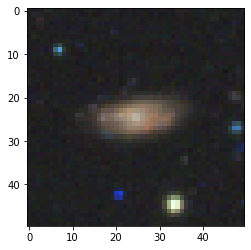

In [7]:
np.random.shuffle(data)
#Let's take a look at one of the images. If you rerun this cell, even though the index of the image stays the same, you will
#see a different image. This is because the dataset is getting reshuffled everytime.
plt.imshow(data[11111][0])
print(Categories[int(data[11111][1])])

## Getting the dataset ready for the Machine Learning Algorithm

Alright, so we have a balanced, shuffled dataset. Let's get it ready for our machine learning algorithm. We'll have to split our dataset into the training images and the testing images. The training images will be used to train the machine learning algorithm and the testing images will be used to test the algorithm to see its accuracy.

In [8]:
test_frac = 0.1 #This is the fraction of the total images that will be saved for testing
n_test = int(len(data)*test_frac)

train_images = []
train_labels = []
test_images = []
test_labels = []

for i in range(len(data)):
    if i<n_test:
        test_images.append(data[i][0])
        test_labels.append(data[i][1])
    else:
        train_images.append(data[i][0])
        train_labels.append(data[i][1])
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

Our dataset is now ready to feed to the machine learning algorithm! So we don't have to do this entire process again, let's use pickle to save our training and testing datasets.

In [9]:
#feel free to modify the path and names to something you'll remember
pickle_out = open('images/{}_train_images.pickle'.format(img_size), 'wb')
pickle.dump(train_images, pickle_out)
pickle_out.close()

pickle_out = open('images/{}_train_labels.pickle'.format(img_size), 'wb')
pickle.dump(train_labels, pickle_out)
pickle_out.close()

pickle_out = open('images/{}_test_images.pickle'.format(img_size), 'wb')
pickle.dump(test_images, pickle_out)
pickle_out.close()

pickle_out = open('images/{}_test_labels.pickle'.format(img_size), 'wb')
pickle.dump(test_labels, pickle_out)
pickle_out.close()

## Creating the Model

If you're comming back after creating the dataset, you can load the data you created last time using pickle. Make sure to modify the code below if you change the name of your file or the path to it.

In [10]:
train_images = pickle.load(open('images/50_train_images.pickle', 'rb'))
train_labels = pickle.load(open('images/50_train_labels.pickle', 'rb'))
test_images = pickle.load(open('images/50_test_images.pickle', 'rb'))
test_labels = pickle.load(open('images/50_test_labels.pickle', 'rb'))

You'll also have to run the 'Categories' cell again, so it's been written again below:

In [11]:
n_cat = np.ptp(train_labels)+1

Categories = None

if n_cat == 10:
    Categories = ['Disturbed ',
    'Merging',
    'Round Smooth',
    'In-between Round Smooth',
    'Cigar Shaped Smooth',
    'Barred Spiral',
    'Unbarred Tight Spiral',
    'Unbarred Loose Spiral',
    'Edge-on without Bulge',
    'Edge-on with Bulge',]
    
if n_cat == 9:
    Categories = ['Merging',
    'Round Smooth',
    'In-between Round Smooth',
    'Cigar Shaped Smooth',
    'Barred Spiral',
    'Unbarred Tight Spiral',
    'Unbarred Loose Spiral',
    'Edge-on without Bulge',
    'Edge-on with Bulge',]
    
if n_cat == 5:
    Categories = ['Disturbed','Merging','Smooth', 'Spiral', 'Edge-on']

if n_cat == 4:
    Categories = ['Merging','Smooth', 'Spiral', 'Edge-on']
    
if n_cat == 3:
    Categories = ['Smooth', 'Spiral', 'Edge-on']

We can make sure everything is loaded properly by taking a look at one of the galaxies.

Unbarred Loose Spiral


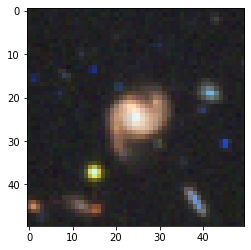

In [12]:
idx = np.random.randint(0, np.shape(train_images)[0])
img_size = int(np.shape(train_images[idx])[0])

plt.imshow(train_images[idx])
print(Categories[int(train_labels[idx])])

We're finally ready to write our machine learning algorithm! Here is the model that we found works best for us in classifying 50x50 images of galaxies:

In [13]:
clear_session()

model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (img_size,img_size,3))) #Input layer
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation = 'sigmoid')) #1st hidden convolutional layer
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation = 'sigmoid')) #2nd hidden convolutional layer
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Dropout(0.02)) #The dropout layer randomly sets a percentage of the "knobs" of the algorithm to 0 to help prevent
                         #overfitting.
model.add(Conv2D(64, (3,3), activation = 'sigmoid')) #Final hidden convolutional layer
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())

model.add(Dense(64, activation = 'sigmoid'))

model.add(Dense(n_cat, activation = 'sigmoid')) #Output layer

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

There are so many different parameters you could change in our model, so go ahead and experiment with different options if you'd like. If you don't know where to start, you could try changing the number of hidden convolutional layers, you could change some of the activation functions, you could change the convolution size, etc.

## Training the Model

Alright, so we've got the balanced, shuffled dataset and we now have created a model for our machine learning algorithm, so it's time to train it! The batch size below just denotes the number of images you are feeding to the algorithm at once. The number of epochs denotes how long you'd like to train your algorithm. Typically, increasing the number of epochs will increase the accuracy of the algorithm, up to a certain point where the accuracy will flatten off. The validation split is the fraction of training images that the algorithm will put aside to test the changes it makes after each epoch. Feel free to mess around with these parameters to see how changing them affects the accuracy of the algorithm

In [14]:
history = model.fit(train_images,train_labels, batch_size = 64, epochs = 30, validation_split = 0.2)

Epoch 1/30
298/298 [==============================] - 27s 87ms/step - loss: 2.2476 - accuracy: 0.1339 - val_loss: 2.1039 - val_accuracy: 0.1941
Epoch 2/30
298/298 [==============================] - 27s 89ms/step - loss: 1.9677 - accuracy: 0.2799 - val_loss: 1.8455 - val_accuracy: 0.3347
Epoch 3/30
298/298 [==============================] - 27s 90ms/step - loss: 1.6760 - accuracy: 0.3915 - val_loss: 1.5845 - val_accuracy: 0.4107
Epoch 4/30
298/298 [==============================] - 27s 90ms/step - loss: 1.5354 - accuracy: 0.4432 - val_loss: 1.5075 - val_accuracy: 0.4487
Epoch 5/30
298/298 [==============================] - 27s 90ms/step - loss: 1.4572 - accuracy: 0.4773 - val_loss: 1.4452 - val_accuracy: 0.4834
Epoch 6/30
298/298 [==============================] - 27s 90ms/step - loss: 1.3918 - accuracy: 0.5059 - val_loss: 1.3958 - val_accuracy: 0.5059
Epoch 7/30
298/298 [==============================] - 27s 90ms/step - loss: 1.3349 - accuracy: 0.5266 - val_loss: 1.3277 - val_accuracy:

Alright, our machine learning algorithm is trained, but how can we see it's performance? Let's start by producing some accuracy and loss curves.

In [15]:
def plot_history(history):
    fig, axes = plt.subplots(2,1, figsize = (8,5))
    
    axes[0].plot(history.history['accuracy'],'bo--', label = 'Accuracy')
    axes[0].plot(history.history['val_accuracy'],'ro--', label = 'Validation Accuracy')
    axes[0].set_ylabel('Accuracy', fontsize=16)
    axes[0].legend(fontsize=16)
    
    axes[1].plot(history.history['loss'],'bo--', label = 'Loss')
    axes[1].plot(history.history['val_loss'],'ro--', label = 'Validation Loss')
    axes[1].set_ylabel('Loss', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=16)
    axes[1].legend(fontsize=16)
    
    
    fig.tight_layout()

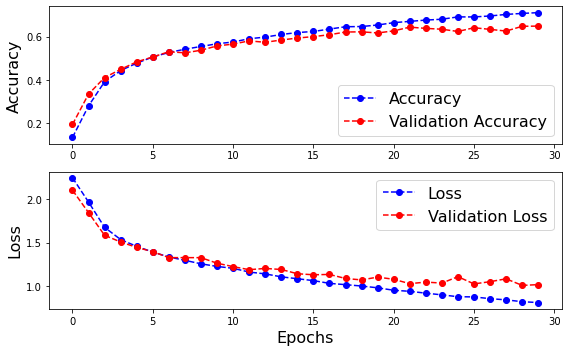

In [16]:
plot_history(history)

These figures above show how the accuracy, validation accuracy, loss and validation loss all change as we run the algorithm for multiple epochs. The *validation* curves represent the algorithm testing itself with the images we set aside with our `validation_split` parameter. The other curves represent the accuracy and loss of the in sample images.

Let's check exactly how well our algorithm is performing in classifying the different galaxy morphologies.

In [17]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)

print(classification_report(test_labels, pred_labels, target_names = Categories))

                         precision    recall  f1-score   support

             Disturbed        0.37      0.51      0.43       262
                Merging       0.74      0.72      0.73       258
           Round Smooth       0.86      0.80      0.83       249
In-between Round Smooth       0.81      0.80      0.80       280
    Cigar Shaped Smooth       0.53      0.48      0.51       258
          Barred Spiral       0.67      0.54      0.59       283
  Unbarred Tight Spiral       0.65      0.67      0.66       271
  Unbarred Loose Spiral       0.46      0.50      0.48       270
  Edge-on without Bulge       0.82      0.87      0.85       243
     Edge-on with Bulge       0.85      0.74      0.79       270

               accuracy                           0.66      2644
              macro avg       0.68      0.66      0.67      2644
           weighted avg       0.68      0.66      0.67      2644



The most important columns in the table above are **precision** and **recall**. Precision is how many times when it guess a specific galaxy did it guess right. Recall is how many times it guessed the right galaxy type when presented with a galaxy of that type. Support just denotes the number of testing images for each galaxy type.

As you can see, by taking into account all categories we only reach a precision of around 65%. To improve this, we can group similar galaxies together. For example, we can group round smooth, in-between round smooth and cigar shaped smooth all together as smooth galaxies, we can group barred spiral, unbarred tight spiral and unbarred loose spiral together as spiral galaxies, and finally join together edge-on without bulge and edge-on with bulge as simply edge-on galaxies. You can also experiment more with removing the disturbed category$^1$ and the merging category$^2$ to reach an accuracy of 91%. To do this, simply go back in the code when we were generating the dataset and uncomment out the regions that you skipped over before.

$^1$ We first might want to remove the disturbed galaxies category as this is just a catch-all term for all galaxies that don't fit in the other 9 categories. For this reason, they are less likely to have similar features than the other 9 categories, thus making it hard for the algorithm to pick up on patterns that would make it better at classifying said galaxies.

$^2$ We then may want to remove the merging galaxies category as this can sometimes cause issues. This is because each galaxy picture only has a single label, so if you have 2 spiral galaxies merging, then it will simply be labelled as a merging galaxy. But sometimes our machine will not be sure whether to guess merging or spiral in cases like that, so removing the merging category all together increases the accuracy a little bit.

## Final Thoughts

Hopefully you enjoyed learning about and tinkering with a machine learning algorithm. Thanks to libraries like TensorFlow, the ability to create well-performing machine learning algorithms has become much more accessible, and hopefully this project was able to demonstrate that.